In [69]:
import unicodecsv as csv
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from collections import defaultdict


In [2]:
files = ['daily_engagement.csv','enrollments.csv', 'project_submissions.csv']

In [3]:
def reading_file(filename):
    with open(filename,'rb') as file:
        reader = csv.DictReader(file)
        dictionary = list(reader)
    return(dictionary)

In [11]:
daily_engagement = reading_file(files[0])
enrollment = reading_file(files[1])
project_submission = reading_file(files[2])

In [12]:
daily_engagement[0]

OrderedDict([('acct', '0'),
             ('utc_date', '2015-01-09'),
             ('num_courses_visited', '1.0'),
             ('total_minutes_visited', '11.6793745'),
             ('lessons_completed', '0.0'),
             ('projects_completed', '0.0')])

In [13]:
enrollment[0]

OrderedDict([('account_key', '448'),
             ('status', 'canceled'),
             ('join_date', '2014-11-10'),
             ('cancel_date', '2015-01-14'),
             ('days_to_cancel', '65'),
             ('is_udacity', 'True'),
             ('is_canceled', 'True')])

In [14]:
project_submission[0]

OrderedDict([('creation_date', '2015-01-14'),
             ('completion_date', '2015-01-16'),
             ('assigned_rating', 'UNGRADED'),
             ('account_key', '256'),
             ('lesson_key', '3176718735'),
             ('processing_state', 'EVALUATED')])

In [15]:
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    

In [16]:
for row in daily_engagement:
    row['account_key'] = row['acct']
    row['utc_date'] = parse_date(row['utc_date'])
    row['num_courses_visited'] = float(row['num_courses_visited'])
    row['total_minutes_visited'] = float(row['total_minutes_visited'])
    row['lessons_completed'] = float(row['lessons_completed'])
    row['projects_completed'] = float(row['projects_completed'])

In [17]:
daily_engagement[0]

OrderedDict([('acct', '0'),
             ('utc_date', datetime.datetime(2015, 1, 9, 0, 0)),
             ('num_courses_visited', 1.0),
             ('total_minutes_visited', 11.6793745),
             ('lessons_completed', 0.0),
             ('projects_completed', 0.0),
             ('account_key', '0')])

In [19]:
for row in enrollment:
    row['join_date'] = parse_date(row['join_date'])
    row['cancel_date'] = parse_date(row['cancel_date'])
    if row['days_to_cancel'] == '':
        row['days_to_cancel'] = None
    else:
        row['days_to_cancel'] = int(row['days_to_cancel'])
    row['is_udacity'] = row['is_udacity'] == 'True'
    row['is_canceled'] = row['is_canceled'] == 'True'

In [20]:
enrollment[0]

OrderedDict([('account_key', '448'),
             ('status', 'canceled'),
             ('join_date', datetime.datetime(2014, 11, 10, 0, 0)),
             ('cancel_date', datetime.datetime(2015, 1, 14, 0, 0)),
             ('days_to_cancel', 65),
             ('is_udacity', True),
             ('is_canceled', True)])

In [22]:
def unique_account(data):
    unique_account = []
    for row in data:
        if row['account_key'] not in unique_account:
            unique_account.append(row['account_key'])
    return(unique_account)

daily_unique_account = unique_account(daily_engagement)
enroll_unique_account = unique_account(enrollment)
project_unique_account = unique_account(project_submission)

In [23]:
len(daily_unique_account)

1237

In [24]:
len(enroll_unique_account)

1302

In [25]:
len(project_unique_account)

743

In [28]:
zero_days = []
for row in enrollment:
    if row['account_key'] not in daily_unique_account:
        if row['days_to_cancel'] == 0:
            if row['account_key'] not in zero_days:
                zero_days.append(row['account_key'])


In [29]:
len(zero_days)

63

In [30]:
for row in enrollment:
    if row['account_key'] not in daily_unique_account:
        if row['account_key'] not in zero_days:
            print(row)

OrderedDict([('account_key', '1304'), ('status', 'canceled'), ('join_date', datetime.datetime(2015, 1, 10, 0, 0)), ('cancel_date', datetime.datetime(2015, 3, 10, 0, 0)), ('days_to_cancel', 59), ('is_udacity', True), ('is_canceled', True)])
OrderedDict([('account_key', '1304'), ('status', 'canceled'), ('join_date', datetime.datetime(2015, 3, 10, 0, 0)), ('cancel_date', datetime.datetime(2015, 6, 17, 0, 0)), ('days_to_cancel', 99), ('is_udacity', True), ('is_canceled', True)])
OrderedDict([('account_key', '1101'), ('status', 'current'), ('join_date', datetime.datetime(2015, 2, 25, 0, 0)), ('cancel_date', None), ('days_to_cancel', None), ('is_udacity', True), ('is_canceled', False)])


In [35]:
test_accounts = []
for row in enrollment:
    if row['is_udacity'] == True:
        test_accounts.append(row['account_key'])

In [36]:
def non_udacity(data):
    non_udacity = []
    for row in data:
        if row['account_key'] not in test_accounts:
            non_udacity.append(row)
    return(non_udacity)
            

In [37]:
non_udacity_engagement = non_udacity(daily_engagement)
non_udacity_enrollment = non_udacity(enrollment)
non_udacity_submission = non_udacity(project_submission)

In [61]:
paid_students = {}
for row in non_udacity_enrollment:
    account_key = row['account_key']
    enrollment = row['join_date']
    if row['days_to_cancel'] == None or row['days_to_cancel'] > 7:
        if account_key not in paid_students or enrollment > paid_students[account_key]:
            paid_students[account_key] = enrollment

In [68]:
engagement_first_week = []
for row in non_udacity_engagement:
    if row['account_key'] in paid_students:
        account_key = row['account_key']
        join_date = paid_students[account_key]
        engagement_date = row['utc_date']
        
        time_delta = engagement_date - join_date
        
        if time_delta.days >= 0 or time_delta.days <= 7:
            engagement_first_week.append(row)
        

In [70]:
engagement_by_account = defaultdict(list)
for row in engagement_first_week:
    account_key = row['account_key']
    engagement_by_account[account_key].append(row)

In [106]:
def total(term):
    term_to_account = {}
    for account_key, engagement in engagement_by_account.items():
        total_term = 0
        for row in engagement:
            
            total_term += row[term]
        
        term_to_account[account_key] = total_term
        
    return(term_to_account)

In [107]:
minutes_to_account = total('total_minutes_visited')
lesson_to_account = total('lessons_completed')
projects_to_account = total('projects_completed')

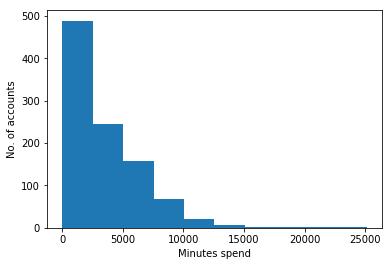

In [108]:
plt.hist(minutes_to_account.values())
plt.xlabel('Minutes spend')
plt.ylabel('No. of accounts')
plt.show()

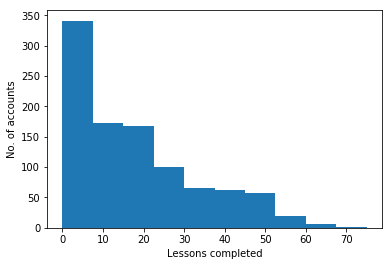

In [110]:
plt.hist(lesson_to_account.values())
plt.xlabel('Lessons completed')
plt.ylabel('No. of accounts')
plt.show()

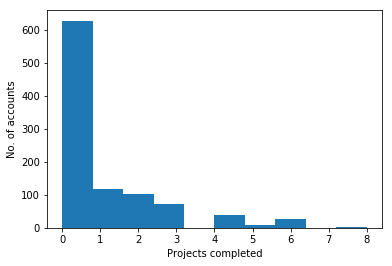

In [111]:
plt.hist(projects_to_account.values())
plt.xlabel('Projects completed')
plt.ylabel('No. of accounts')
plt.show()